In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
pd.set_option('display.max_columns', None)


In [5]:
df = pd.read_csv('../data/probabilities.csv')


In [6]:
df.columns.tolist() 

['year',
 'gisjoin',
 'state',
 'county',
 'P(C)',
 'P(households_income_under_10k|C)',
 'P(households_income_10k_15k|C)',
 'P(households_income_15k_25k|C)',
 'P(households_income_25k_plus|C)',
 'P(persons_male|C)',
 'P(persons_female|C)',
 'P(male_never_married|C)',
 'P(male_married|C)',
 'P(male_separated|C)',
 'P(male_widowed|C)',
 'P(male_divorced|C)',
 'P(female_never_married|C)',
 'P(female_married|C)',
 'P(female_separated|C)',
 'P(female_widowed|C)',
 'P(female_divorced|C)',
 'P(male_18_24_less_than_9th|C)',
 'P(male_18_24_some_hs|C)',
 'P(male_18_24_hs_grad|C)',
 'P(male_18_24_some_college|C)',
 'P(male_18_24_associates|C)',
 'P(male_18_24_bachelors|C)',
 'P(male_18_24_graduate|C)',
 'P(male_25_34_less_than_9th|C)',
 'P(male_25_34_some_hs|C)',
 'P(male_25_34_hs_grad|C)',
 'P(male_25_34_some_college|C)',
 'P(male_25_34_associates|C)',
 'P(male_25_34_bachelors|C)',
 'P(male_25_34_graduate|C)',
 'P(male_35_44_less_than_9th|C)',
 'P(male_35_44_some_hs|C)',
 'P(male_35_44_hs_grad|C

In [7]:
df.shape

(12360, 119)

In [8]:
# Define the columns involved in determining the winner
competitor_columns = ['P(democrat|C)',
 'P(other|C)',
 'P(republican|C)',]

# Check if competitor columns exist
if not all(col in df.columns for col in competitor_columns):
    raise ValueError(f"One or more competitor columns {competitor_columns} not found in DataFrame.")


In [9]:
df[competitor_columns]

,P(democrat|C),P(other|C),P(republican|C)
0,0.114627,0.002728,0.327401
1,0.110279,0.004301,0.348545
2,0.205675,0.002419,0.211777
3,0.101681,0.003671,0.276957
4,0.062125,0.006280,0.359645
...,...,...,...
12355,0.090853,0.015352,0.290620
12356,0.421828,0.025615,0.185942
12357,0.077436,0.018106,0.364840
12358,0.084272,0.017605,0.420065


In [10]:

# Determine the winning category based on max value
df['winning_category'] = df[competitor_columns].idxmax(axis=1)

# Create the binary target: 1 if Democrat wins, 0 otherwise
df['target_democrat_win'] = (df['P(democrat|C)'] > df['P(republican|C)']).astype(int)

y = df['target_democrat_win']
class_names = ['Democrat Lose', 'Democrat Win'] # For plotting/reporting
num_classes = 2 # Binary classification


In [11]:
df

,year,gisjoin,state,county,P(C),P(households_income_under_10k|C),P(households_income_10k_15k|C),P(households_income_15k_25k|C),P(households_income_25k_plus|C),P(persons_male|C),P(persons_female|C),P(male_never_married|C),P(male_married|C),P(male_separated|C),P(male_widowed|C),P(male_divorced|C),P(female_never_married|C),P(female_married|C),P(female_separated|C),P(female_widowed|C),P(female_divorced|C),P(male_18_24_less_than_9th|C),P(male_18_24_some_hs|C),P(male_18_24_hs_grad|C),P(male_18_24_some_college|C),P(male_18_24_associates|C),P(male_18_24_bachelors|C),P(male_18_24_graduate|C),P(male_25_34_less_than_9th|C),P(male_25_34_some_hs|C),P(male_25_34_hs_grad|C),P(male_25_34_some_college|C),P(male_25_34_associates|C),P(male_25_34_bachelors|C),P(male_25_34_graduate|C),P(male_35_44_less_than_9th|C),P(male_35_44_some_hs|C),P(male_35_44_hs_grad|C),P(male_35_44_some_college|C),P(male_35_44_associates|C),P(male_35_44_bachelors|C),P(male_35_44_graduate|C),P(male_45_64_less_than_9th|C),P(male_45_64_some_hs|C),P(male_45_64_hs_grad|C),P(male_45_64_some_college|C),P(male_45_64_associates|C),P(male_45_64_bachelors|C),P(male_45_64_graduate|C),P(male_65plus_less_than_9th|C),P(male_65plus_some_hs|C),P(male_65plus_hs_grad|C),P(male_65plus_some_college|C),P(male_65plus_associates|C),P(male_65plus_bachelors|C),P(male_65plus_graduate|C),P(female_18_24_less_than_9th|C),P(female_18_24_some_hs|C),P(female_18_24_hs_grad|C),P(female_18_24_some_college|C),P(female_18_24_associates|C),P(female_18_24_bachelors|C),P(female_18_24_graduate|C),P(female_25_34_less_than_9th|C),P(female_25_34_some_hs|C),P(female_25_34_hs_grad|C),P(female_25_34_some_college|C),P(female_25_34_associates|C),P(female_25_34_bachelors|C),P(female_25_34_graduate|C),P(female_35_44_less_than_9th|C),P(female_35_44_some_hs|C),P(female_35_44_hs_grad|C),P(female_35_44_some_college|C),P(female_35_44_associates|C),P(female_35_44_bachelors|C),P(female_35_44_graduate|C),P(female_45_64_less_than_9th|C),P(female_45_64_some_hs|C),P(female_45_64_hs_grad|C),P(female_45_64_some_college|C),P(female_45_64_associates|C),P(female_45_64_bachelors|C),P(female_45_64_graduate|C),P(female_65plus_less_than_9th|C),P(female_65plus_some_hs|C),P(female_65plus_hs_grad|C),P(female_65plus_some_college|C),P(female_65plus_associates|C),P(female_65plus_bachelors|C),P(female_65plus_graduate|C),P(male_white|C),P(female_white|C),P(male_black|C),P(female_black|C),P(male_aian|C),P(female_aian|C),P(male_asian|C),P(female_asian|C),P(male_nhpi|C),P(female_nhpi|C),P(male_other|C),P(female_other|C),P(male_multi|C),P(female_multi|C),P(persons_native|C),P(persons_foreign_born|C),P(labor_force_total|C),P(labor_force_armed|C),P(labor_force_civilian|C),P(labor_force_employed|C),P(labor_force_unemployed|C),P(not_in_labor_force|C),P(persons_hispanic|C),P(persons_below_poverty|C),P(democrat|C),P(other|C),P(republican|C),P(non_voter|C),winning_category,target_democrat_win
0,2008,G0100010,Alabama,Autauga County,0.000177,0.066741,0.050512,0.087433,0.795314,0.484997,0.515003,0.104468,0.222256,0.009538,0.008184,0.037588,0.094723,0.220243,0.010121,0.039413,0.051190,0.000602,0.011532,0.015991,0.012435,0.000470,0.001373,0.000000,0.001674,0.006227,0.022199,0.014392,0.001881,0.008071,0.003198,0.003292,0.005192,0.025473,0.018568,0.002671,0.012793,0.006791,0.005493,0.011815,0.038228,0.025040,0.009482,0.021371,0.009764,0.004910,0.005079,0.017948,0.010159,0.001185,0.003932,0.005061,0.000621,0.007205,0.012247,0.017233,0.001674,0.003462,0.000677,0.002220,0.004910,0.020374,0.012812,0.006396,0.012153,0.003330,0.003292,0.005079,0.026075,0.021108,0.007600,0.013301,0.004327,0.003311,0.012116,0.044963,0.026997,0.010742,0.018662,0.010065,0.007168,0.011720,0.029292,0.010573,0.001166,0.003255,0.002559,0.387264,0.403462,0.085034,0.093839,0.001091,0.002069,0.002502,0.004045,0.000000,0.000000,0.003330,0.002765,0.005776,0.008823,0.980152,0.019848,0.501082,0.012849,0.469739,0.457925,0.030308,0.257643,0.023196,0.105785,0.114627,0.002728,0.327401,0.555244,P(republican|C)

In [12]:
print(f"\nTarget variable created: 'target_democrat_win' (Binary)")
print(f"Classes: {class_names}")
print(f"Value counts (0 = Democrat Lose, 1 = Democrat Win):\n{y.value_counts()}")
print(f"Win percentage for Democrat: {y.mean() * 100:.2f}%")



Target variable created: 'target_democrat_win' (Binary)
Classes: ['Democrat Lose', 'Democrat Win']
Value counts (0 = Democrat Lose, 1 = Democrat Win):
target_democrat_win
0    9804
1    2556
Name: count, dtype: int64
Win percentage for Democrat: 20.68%


In [13]:
# Define features (X) - Exclude identifiers and ALL competitor cols, plus the derived target/winner cols
identifier_cols = ['gisjoin', 'state', 'county']
# Keep 'year' for now, assuming it might be a useful feature
feature_cols = [col for col in df.columns if col not in identifier_cols + competitor_columns + ['year','P(democrat|C)',
       'P(other|C)', 'P(republican|C)', 'P(non_voter|C)', 'winning_category',
       'target_democrat_win']]


In [14]:
len(feature_cols)

111

In [15]:
# Ensure all feature columns are numeric - convert if necessary, handle errors robustly
X = df[feature_cols].apply(pd.to_numeric, errors='coerce') # Coerce turns non-numeric into NaN


In [16]:
train_idx = (df["year"] == 2008) | (df["year"] == 2012) 

validation_idx = (df["year"] == 2016)

In [17]:
X_train = X[train_idx]
y_train = y[train_idx]
X_val = X[validation_idx]
y_val = y[validation_idx]
print(f"\nData split: Train shape {X_train.shape}, Test shape {X_val.shape}")
print(f"Train target distribution:{y_train.value_counts(normalize=True)}")
print(f"Validation target distribution:\n{y_val.value_counts(normalize=True)}")


Data split: Train shape (6180, 111), Test shape (3090, 111)
Train target distribution:target_democrat_win
0    0.749676
1    0.250324
Name: proportion, dtype: float64
Validation target distribution:
target_democrat_win
0    0.84466
1    0.15534
Name: proportion, dtype: float64


In [18]:
y_train, y_val

(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 6175    0
 6176    1
 6177    0
 6178    0
 6179    0
 Name: target_democrat_win, Length: 6180, dtype: int64,
 6180    0
 6181    0
 6182    0
 6183    0
 6184    0
        ..
 9265    0
 9266    1
 9267    0
 9268    0
 9269    0
 Name: target_democrat_win, Length: 3090, dtype: int64)

In [19]:
# Fit scaler on training data only
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)

# Transform validation and test sets using training parameters
X_val_scaled = scaler.transform(X_val)


In [20]:
X_tr_tensor = torch.FloatTensor(X_tr_scaled)
y_tr_tensor = torch.FloatTensor(y_train.values)  # Convert Series to NumPy array

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values)  # Convert Series to NumPy array


In [21]:
X_tr_tensor

tensor([[-0.1414, -0.4803, -0.7481,  ..., -0.8928, -0.4503, -0.8186],
        [ 0.2537, -0.6658, -0.8407,  ..., -0.0219, -0.3300, -0.5752],
        [-0.2234,  2.3103,  1.2226,  ...,  1.3166, -0.2766,  1.1116],
        ...,
        [-0.2472, -0.4677, -0.5342,  ..., -1.3566,  0.0513, -0.2538],
        [-0.2863, -0.2451,  0.1455,  ..., -0.5341,  0.4313, -0.2697],
        [-0.2903, -0.6464, -0.2721,  ..., -0.0672, -0.3482, -0.6281]])

In [22]:

# or CUDA availability on machines with NVIDIA GPUs
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

# Move tensor to appropriate device
device = torch.device(device)
print(f"Using device: {device}")

Using device: mps


In [29]:
# --- 1. Move data to device ---
# Convert training and validation data to PyTorch tensors and move them to the specified device (e.g., GPU or CPU)
X_tr_tensor = torch.FloatTensor(X_tr_scaled).to(device)
y_tr_tensor = torch.FloatTensor(y_train.values).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).to(device)

# --- 2. Create DataLoader ---
# Define batch size for training and validation
batch_size = 64

# Create TensorDataset objects for training and validation datasets
train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoader objects for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# --- 3. Define Neural Network ---
# Define a binary classification neural network with 3 layers
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),  # Input layer to hidden layer 1
            nn.ReLU(),                 # Activation function
            nn.Dropout(0.3),           # Dropout for regularization
            nn.Linear(128, 64),        # Hidden layer 1 to hidden layer 2
            nn.ReLU(),                 # Activation function
            nn.Dropout(0.3),           # Dropout for regularization
            nn.Linear(64, 1),          # Hidden layer 2 to output layer
            nn.Sigmoid()               # Sigmoid activation for binary classification
        )
        
    def forward(self, x):
        return self.net(x)

# Instantiate the model and move it to the specified device
NN_3_layer_model = BinaryClassifier(X_tr_tensor.shape[1]).to(device)
print(NN_3_layer_model)

# --- 4. Loss and Optimizer ---
# Define the loss function (Binary Cross-Entropy Loss) and optimizer (Adam)
criterion = nn.BCELoss()
optimizer = optim.Adam(NN_3_layer_model.parameters())

# --- 5. Early Stopping Setup ---
# Define an EarlyStopping class to stop training when validation loss stops improving
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, NN_3_layer_model):
        if val_loss < self.best_loss:
            # Save the best model state and reset the counter
            self.best_loss = val_loss
            self.best_model_state = NN_3_layer_model.state_dict()
            self.counter = 0
        else:
            # Increment the counter and check if patience is exceeded
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                NN_3_layer_model.load_state_dict(self.best_model_state)

# Instantiate the EarlyStopping object
early_stopping = EarlyStopping(patience=10)

# Define the number of epochs for training
epochs = 50
print("Starting model training...")

# Initialize lists to store training and validation metrics
train_loss_history = []
val_loss_history = []
val_accuracy_history = []

# --- 6. Training Loop ---
for epoch in range(epochs):
    # Set the model to training mode
    NN_3_layer_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = NN_3_layer_model(X_batch).squeeze()
        # Compute the loss
        loss = criterion(outputs, y_batch)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Accumulate the loss
        total_loss += loss.item()
    
    # Compute average training loss for the epoch
    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # Set the model to evaluation mode
    NN_3_layer_model.eval()
    with torch.no_grad():
        # Compute validation loss
        val_outputs = NN_3_layer_model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_loss_history.append(val_loss)

        # Compute validation accuracy
        val_preds = (val_outputs >= 0.5).float()
        accuracy = (val_preds == y_val_tensor).float().mean().item()
        val_accuracy_history.append(accuracy)

    # Print metrics for the current epoch
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {accuracy:.4f}")

    # Check for early stopping
    early_stopping(val_loss, NN_3_layer_model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print("Model training finished.")

# --- 7. Evaluation ---
# Evaluate the model on the validation set
NN_3_layer_model.eval()
with torch.no_grad():
    val_outputs = NN_3_layer_model(X_val_tensor).squeeze()
    predicted = (val_outputs >= 0.5).float()
    accuracy = (predicted == y_val_tensor).float().mean().item()
    final_loss = criterion(val_outputs, y_val_tensor).item()

# Print final evaluation metrics
print(f"\nTest Loss: {final_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

BinaryClassifier(
  (net): Sequential(
    (0): Linear(in_features=111, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Starting model training...
Epoch 1/50 | Train Loss: 0.4483 | Val Loss: 0.2419 | Val Accuracy: 0.9262
Epoch 2/50 | Train Loss: 0.3384 | Val Loss: 0.2137 | Val Accuracy: 0.9249
Epoch 3/50 | Train Loss: 0.3098 | Val Loss: 0.1849 | Val Accuracy: 0.9317
Epoch 4/50 | Train Loss: 0.2883 | Val Loss: 0.1823 | Val Accuracy: 0.9278
Epoch 5/50 | Train Loss: 0.2801 | Val Loss: 0.1682 | Val Accuracy: 0.9343
Epoch 6/50 | Train Loss: 0.2657 | Val Loss: 0.1776 | Val Accuracy: 0.9324
Epoch 7/50 | Train Loss: 0.2572 | Val Loss: 0.1698 | Val Accuracy: 0.9330
Epoch 8/50 | Train Loss: 0.2449 | Val Loss: 0.1879 | Val Accuracy: 0.9210
Epoch 9/50 | Train Loss: 

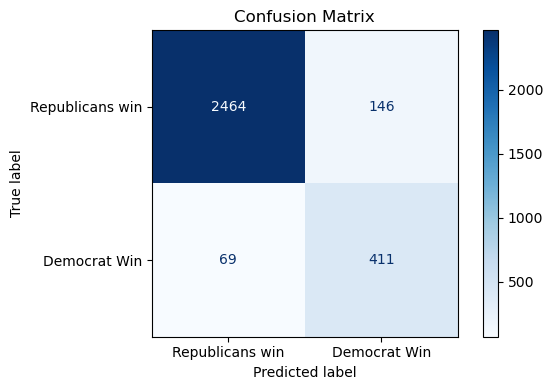


Classification Report:
                 precision    recall  f1-score   support

Republicans win       0.97      0.94      0.96      2610
   Democrat Win       0.74      0.86      0.79       480

       accuracy                           0.93      3090
      macro avg       0.86      0.90      0.88      3090
   weighted avg       0.94      0.93      0.93      3090



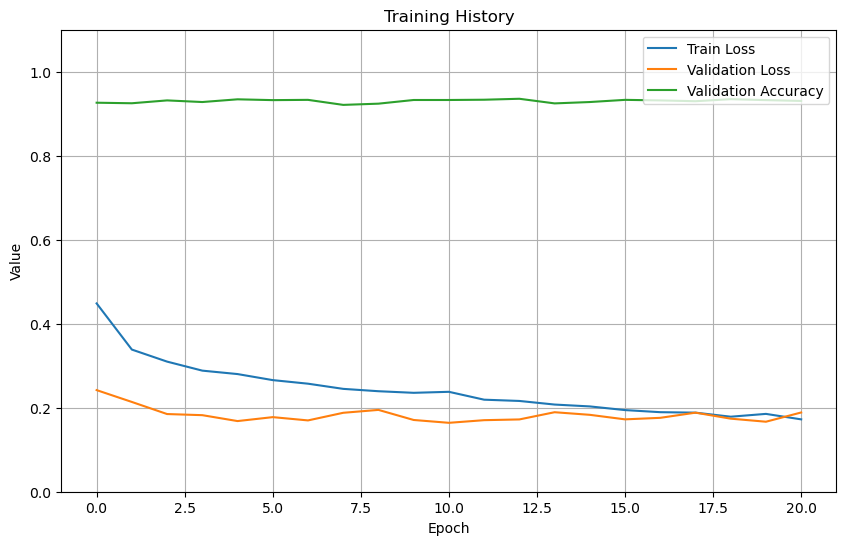

In [30]:
# --- 1. Predict on validation set ---
NN_3_layer_model.eval()
with torch.no_grad():
    y_pred_proba = NN_3_layer_model(X_val_tensor).squeeze().cpu().numpy()  # Convert to NumPy array
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# --- 2. Prepare ground truth labels ---
y_test_flat = y_val_tensor.cpu().numpy().flatten()

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_test_flat, y_pred)
class_names = ['Republicans win', 'Democrat Win']  # Adjust this as needed

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- 4. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred, target_names=class_names))


history_df = pd.DataFrame({
    "Train Loss": train_loss_history,
    "Validation Loss": val_loss_history,
    "Validation Accuracy": val_accuracy_history
})

history_df.plot(figsize=(10, 6))
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.ylim(0, 1.1 * max(history_df.max().max(), 1))
plt.legend(loc='upper right')
plt.show()

BinaryClassifier(
  (layer): Sequential(
    (0): Linear(in_features=111, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Sigmoid()
  )
)
Starting model training...
Epoch 1/50 | Train Loss: 0.4852 | Val Loss: 0.3175 | Val Accuracy: 0.8981
Epoch 2/50 | Train Loss: 0.3731 | Val Loss: 0.2667 | Val Accuracy: 0.9097
Epoch 3/50 | Train Loss: 0.3349 | Val Loss: 0.2182 | Val Accuracy: 0.9227
Epoch 4/50 | Train Loss: 0.3132 | Val Loss: 0.2053 | Val Accuracy: 0.9291
Epoch 5/50 | Train Loss: 0.3041 | Val Loss: 0.2030 | Val Accuracy: 0.9291
Epoch 6/50 | Train Loss: 0.2901 | Val Loss: 0.1897 | Val Accuracy: 0.9275
Epoch 7/50 | Train Loss: 0.2837 | Val Loss: 0.2012 | Val Accuracy: 0.9230
Epoch 8/50 | Train Loss: 0.2755 | Val Loss: 0.1755 | Val Accuracy: 0.9350
Epoch 9/50 | Train Loss: 0.2723 | Val Loss: 0.1791 | Val Accuracy: 0.9324
Epoch 10/50 | Train Loss: 0.2637 | Val Loss: 0.1722 | Val Accuracy

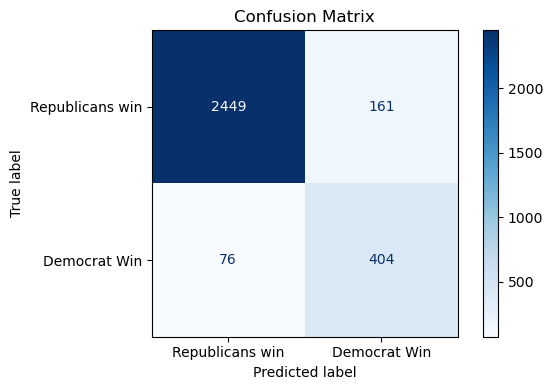


Classification Report:
                 precision    recall  f1-score   support

Republicans win       0.97      0.94      0.95      2610
   Democrat Win       0.72      0.84      0.77       480

       accuracy                           0.92      3090
      macro avg       0.84      0.89      0.86      3090
   weighted avg       0.93      0.92      0.93      3090



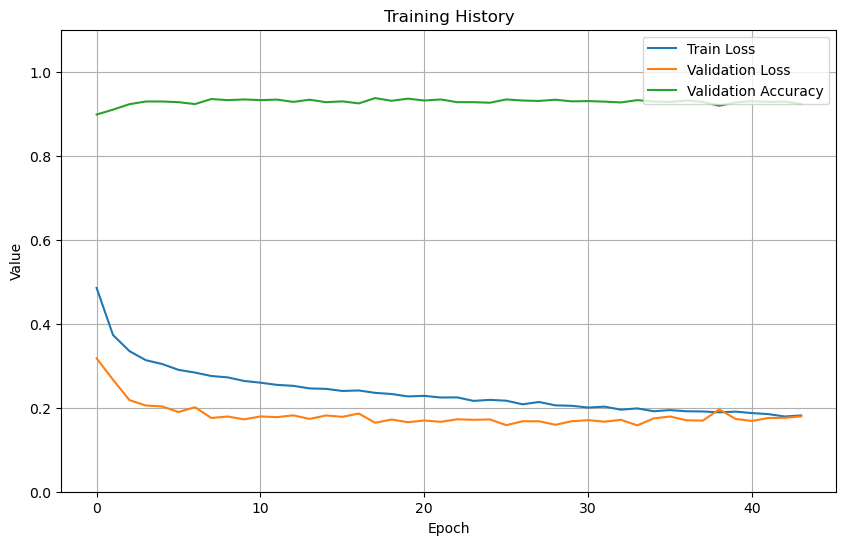

In [31]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 64),  # Linear layer: input_dim -> 64
            nn.ReLU(),  # ReLU activation function
            nn.Dropout(0.3),  # Dropout layer with 30% dropout rate
            nn.Linear(64, 1),  # Linear layer: 64 -> 1 (single output)
            nn.Sigmoid()  # Sigmoid activation for binary classification (0 or 1)
        )
        
    def forward(self, x):
        return self.layer(x)

NN_2_layer_model = BinaryClassifier(X_tr_tensor.shape[1]).to(device)  # Instantiate the model and move it to the specified device
print(NN_2_layer_model)  # Print the model architecture

# --- 4. Loss and Optimizer ---
criterion = nn.BCELoss()  # Binary Cross Entropy Loss (suitable for binary classification)
optimizer = optim.Adam(NN_2_layer_model.parameters())  # Adam optimizer for training the model

# --- 5. Early Stopping Setup ---
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience  # Number of epochs to wait after last time validation loss improved.
        self.counter = 0  # Counter to track how many epochs without improvement
        self.best_loss = float('inf')  # Initialize best loss as infinity
        self.best_model_state = None  # Store the best model state
        self.early_stop = False  # Flag to indicate when to stop training

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:  # If current validation loss is better than the best loss
            self.best_loss = val_loss  # Update the best loss
            self.best_model_state = model.state_dict()  # Save the current model's state
            self.counter = 0  # Reset the counter
        else:
            self.counter += 1  # Increment the counter
            if self.counter >= self.patience:  # If no improvement for 'patience' epochs
                self.early_stop = True  # Trigger early stopping
                model.load_state_dict(self.best_model_state)  # Load the best model state

early_stopping = EarlyStopping(patience=10)  # Instantiate EarlyStopping with a patience of 10 epochs

epochs = 50  # Number of training epochs
print("Starting model training...")

train_loss_history = []  # Store training loss history
val_loss_history = []  # Store validation loss history
val_accuracy_history = []  # Store validation accuracy history

for epoch in range(epochs):
    NN_2_layer_model.train()  # Set the model to training mode
    total_loss = 0
    for X_batch, y_batch in train_loader:  # Iterate through the training data in batches
        optimizer.zero_grad()  # Zero the gradients
        outputs = NN_2_layer_model(X_batch).squeeze()  # Forward pass: compute the model's output
        loss = criterion(outputs, y_batch)  # Compute the loss
        loss.backward()  # Backpropagation: compute the gradients
        optimizer.step()  # Update the model's parameters
        total_loss += loss.item()  # Accumulate the loss
    
    avg_train_loss = total_loss / len(train_loader)  # Compute the average training loss
    train_loss_history.append(avg_train_loss)  # Store the average training loss

    NN_2_layer_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        val_outputs = NN_2_layer_model(X_val_tensor).squeeze()  # Forward pass on the validation set
        val_loss = criterion(val_outputs, y_val_tensor).item()  # Compute the validation loss
        val_loss_history.append(val_loss)  # Store the validation loss

        val_preds = (val_outputs >= 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
        accuracy = (val_preds == y_val_tensor).float().mean().item()  # Compute the validation accuracy
        val_accuracy_history.append(accuracy)  # Store the validation accuracy

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {accuracy:.4f}")  # Print the training progress

    early_stopping(val_loss, NN_2_layer_model)  # Check for early stopping
    if early_stopping.early_stop:  # If early stopping is triggered
        print("Early stopping triggered.")
        break


print("Model training finished.")

# --- 7. Evaluation ---
NN_2_layer_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for evaluation
    val_outputs = NN_2_layer_model(X_val_tensor).squeeze()  # Forward pass on the validation set
    predicted = (val_outputs >= 0.5).float()  # Convert probabilities to binary predictions
    accuracy = (predicted == y_val_tensor).float().mean().item()  # Compute the accuracy
    final_loss = criterion(val_outputs, y_val_tensor).item()  # Compute the loss

print(f"\nTest Loss: {final_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
# --- 1. Predict on validation set ---
NN_2_layer_model.eval()
with torch.no_grad():
    y_pred_proba = NN_2_layer_model(X_val_tensor).squeeze().cpu().numpy()  # Convert to NumPy array
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# --- 2. Prepare ground truth labels ---
y_test_flat = y_val_tensor.cpu().numpy().flatten()

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_test_flat, y_pred)
class_names = ['Republicans win', 'Democrat Win']  # Adjust this as needed

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- 4. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred, target_names=class_names))


history_df = pd.DataFrame({
    "Train Loss": train_loss_history,
    "Validation Loss": val_loss_history,
    "Validation Accuracy": val_accuracy_history
})

history_df.plot(figsize=(10, 6))
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.ylim(0, 1.1 * max(history_df.max().max(), 1))
plt.legend(loc='upper right')
plt.show()


BinaryClassifier(
  (layer): Sequential(
    (0): Linear(in_features=111, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
Starting model training...
Epoch 1/50 | Train Loss: 0.6279 | Val Loss: 0.5442 | Val Accuracy: 0.7602
Epoch 2/50 | Train Loss: 0.5269 | Val Loss: 0.4857 | Val Accuracy: 0.7935
Epoch 3/50 | Train Loss: 0.4872 | Val Loss: 0.4506 | Val Accuracy: 0.8168
Epoch 4/50 | Train Loss: 0.4603 | Val Loss: 0.4113 | Val Accuracy: 0.8375
Epoch 5/50 | Train Loss: 0.4390 | Val Loss: 0.3916 | Val Accuracy: 0.8540
Epoch 6/50 | Train Loss: 0.4225 | Val Loss: 0.3693 | Val Accuracy: 0.8618
Epoch 7/50 | Train Loss: 0.4087 | Val Loss: 0.3597 | Val Accuracy: 0.8699
Epoch 8/50 | Train Loss: 0.3973 | Val Loss: 0.3361 | Val Accuracy: 0.8809
Epoch 9/50 | Train Loss: 0.3868 | Val Loss: 0.3245 | Val Accuracy: 0.8864
Epoch 10/50 | Train Loss: 0.3785 | Val Loss: 0.3113 | Val Accuracy: 0.8945
Epoch 11/50 | Train Loss: 0.3709 | Val Loss: 0.3031 | Val Accuracy: 0.9019
Epoch 12/50 | Train Loss: 0.363

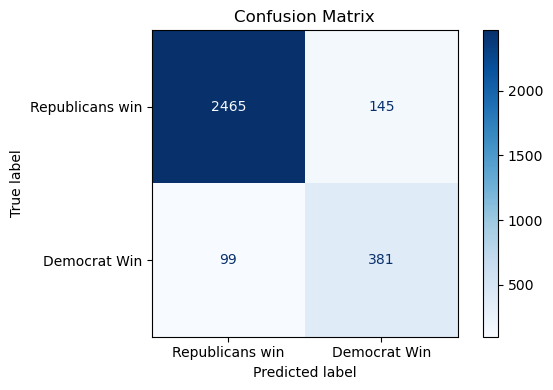


Classification Report:
                 precision    recall  f1-score   support

Republicans win       0.96      0.94      0.95      2610
   Democrat Win       0.72      0.79      0.76       480

       accuracy                           0.92      3090
      macro avg       0.84      0.87      0.86      3090
   weighted avg       0.92      0.92      0.92      3090



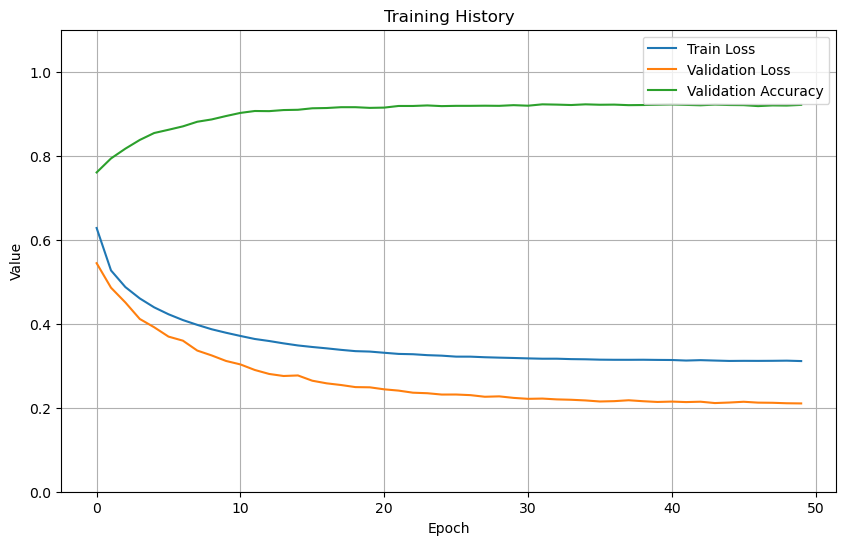

In [32]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 1),  # Linear layer to map input to a single output
            nn.Sigmoid()  # Logistic regression: linear layer + sigmoid activation
        )

    def forward(self, x):
        return self.layer(x)

logistic_reg_model = BinaryClassifier(X_tr_tensor.shape[1]).to(device) # Create and move model to device
print(logistic_reg_model)

# --- 4. Loss and Optimizer ---
criterion = nn.BCELoss() # Binary Cross Entropy Loss for classification
optimizer = optim.Adam(logistic_reg_model.parameters()) # Adam optimizer

# --- 5. Early Stopping Setup ---
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience # Number of epochs to wait after last time validation loss improved.
        self.counter = 0 # Counter that increments every time validation loss doesn't improve.
        self.best_loss = float('inf') # Initialize best loss as infinity
        self.best_model_state = None # Stores the state of the best model
        self.early_stop = False # Flag to indicate when to stop the training

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss: # If validation loss is better than the best loss
            self.best_loss = val_loss # Update the best loss
            self.best_model_state = model.state_dict() # Save the current model state
            self.counter = 0 # Reset counter
        else:
            self.counter += 1 # Increment counter if validation loss doesn't improve
            if self.counter >= self.patience: # Check if early stopping condition is met
                self.early_stop = True # Set early stop flag
                model.load_state_dict(self.best_model_state) # Load the best model state

early_stopping = EarlyStopping(patience=10) # Initialize early stopping

epochs = 50 # Number of training epochs
print("Starting model training...")

train_loss_history = [] # Store training loss per epoch
val_loss_history = [] # Store validation loss per epoch
val_accuracy_history = [] # Store validation accuracy per epoch

for epoch in range(epochs):
    logistic_reg_model.train() # Set the model to training mode
    total_loss = 0
    for X_batch, y_batch in train_loader: # Iterate through the training data
        optimizer.zero_grad() # Clear previously calculated gradients
        outputs = logistic_reg_model(X_batch).squeeze() # Forward pass: compute predicted outputs
        loss = criterion(outputs, y_batch) # Compute loss
        loss.backward() # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step() # Update model parameters
        total_loss += loss.item() # Accumulate the loss
    
    avg_train_loss = total_loss / len(train_loader) # Calculate average training loss
    train_loss_history.append(avg_train_loss) # Store average training loss

    logistic_reg_model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation for validation
        val_outputs = logistic_reg_model(X_val_tensor).squeeze() # Forward pass on validation data
        val_loss = criterion(val_outputs, y_val_tensor).item() # Calculate validation loss
        val_loss_history.append(val_loss) # Store validation loss

        val_preds = (val_outputs >= 0.5).float() # Convert probabilities to predictions (0 or 1)
        accuracy = (val_preds == y_val_tensor).float().mean().item() # Calculate validation accuracy
        val_accuracy_history.append(accuracy) # Store validation accuracy

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {accuracy:.4f}")

    early_stopping(val_loss, logistic_reg_model) # Check for early stopping
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


print("Model training finished.")

# --- 7. Evaluation ---
logistic_reg_model.eval() # Set the model to evaluation mode
with torch.no_grad(): # Disable gradient calculation for evaluation
    val_outputs = logistic_reg_model(X_val_tensor).squeeze() # Forward pass on validation data
    predicted = (val_outputs >= 0.5).float() # Convert probabilities to predictions
    accuracy = (predicted == y_val_tensor).float().mean().item() # Calculate accuracy
    final_loss = criterion(val_outputs, y_val_tensor).item() # Calculate loss

print(f"\nTest Loss: {final_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- 1. Predict on validation set ---
logistic_reg_model.eval() # Set the model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    y_pred_proba = logistic_reg_model(X_val_tensor).squeeze().cpu().numpy()  # Convert to NumPy array
    y_pred = (y_pred_proba > 0.5).astype(int).flatten() # Threshold probabilities to get class predictions

# --- 2. Prepare ground truth labels ---
y_test_flat = y_val_tensor.cpu().numpy().flatten() # Move ground truth labels to CPU and flatten

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_test_flat, y_pred) # Generate confusion matrix
class_names = ['Republicans win', 'Democrat Win']  # Adjust this as needed

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # Create confusion matrix display
fig, ax = plt.subplots(figsize=(6, 4)) # Create figure and axes
disp.plot(ax=ax, cmap=plt.cm.Blues) # Plot confusion matrix
plt.title('Confusion Matrix') # Set title
plt.tight_layout() # Adjust layout
plt.show() # Show plot

# --- 4. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred, target_names=class_names)) # Print classification report


history_df = pd.DataFrame({ # Create a Pandas DataFrame to store training history
    "Train Loss": train_loss_history,
    "Validation Loss": val_loss_history,
    "Validation Accuracy": val_accuracy_history
})

history_df.plot(figsize=(10, 6)) # Plot training history
plt.title("Training History") # Set title
plt.xlabel("Epoch") # Set x-axis label
plt.ylabel("Value") # Set y-axis label
plt.grid(True) # Show grid
plt.ylim(0, 1.1 * max(history_df.max().max(), 1)) # Set y-axis limits
plt.legend(loc='upper right') # Show legend
plt.show() # Show plot

LinearRegressionModel(
  (linear): Linear(in_features=111, out_features=1, bias=True)
)
Starting model training...
Epoch 1/50 | Train Loss: 0.3125 | Val Loss: 0.1371 | Val Accuracy: 0.8809
Epoch 2/50 | Train Loss: 0.1936 | Val Loss: 0.0985 | Val Accuracy: 0.9100
Epoch 3/50 | Train Loss: 0.1475 | Val Loss: 0.0841 | Val Accuracy: 0.9126
Epoch 4/50 | Train Loss: 0.1269 | Val Loss: 0.0747 | Val Accuracy: 0.9285
Epoch 5/50 | Train Loss: 0.1182 | Val Loss: 0.0778 | Val Accuracy: 0.9230
Epoch 6/50 | Train Loss: 0.1144 | Val Loss: 0.0757 | Val Accuracy: 0.9233
Epoch 7/50 | Train Loss: 0.1140 | Val Loss: 0.0760 | Val Accuracy: 0.9275
Epoch 8/50 | Train Loss: 0.1121 | Val Loss: 0.0758 | Val Accuracy: 0.9272
Epoch 9/50 | Train Loss: 0.1120 | Val Loss: 0.0763 | Val Accuracy: 0.9243
Epoch 10/50 | Train Loss: 0.1116 | Val Loss: 0.0806 | Val Accuracy: 0.9220
Epoch 11/50 | Train Loss: 0.1119 | Val Loss: 0.0792 | Val Accuracy: 0.9239
Epoch 12/50 | Train Loss: 0.1116 | Val Loss: 0.0778 | Val Accuracy: 0

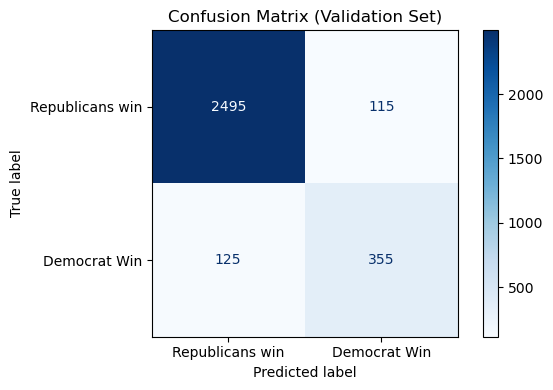


Classification Report (Validation Set):
                 precision    recall  f1-score   support

Republicans win       0.95      0.96      0.95      2610
   Democrat Win       0.76      0.74      0.75       480

       accuracy                           0.92      3090
      macro avg       0.85      0.85      0.85      3090
   weighted avg       0.92      0.92      0.92      3090



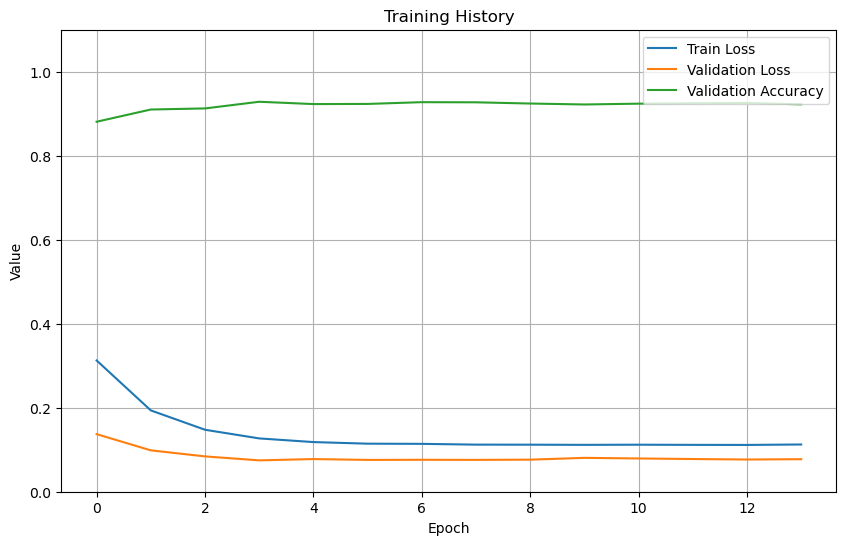

In [33]:
# --- 3. Model Definition ---
# Define a simple linear regression model using PyTorch's nn.Module
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        # Initialize the parent class (nn.Module)
        super(LinearRegressionModel, self).__init__()
        # Define a single linear layer that maps input_dim features to 1 output feature
        # This layer will learn the weights and bias for the linear regression equation.
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        # Define the forward pass: simply pass the input through the linear layer
        # This calculates the prediction: y = Wx + b
        return self.linear(x)

# Instantiate the linear regression model
# X_tr_tensor.shape[1] provides the number of input features (dimensionality of the input data)
# .to(device) moves the model's parameters and buffers to the specified device (e.g., 'cuda' or 'cpu' or 'mps')
lin_model = LinearRegressionModel(X_tr_tensor.shape[1]).to(device)
# Print the model architecture to verify its structure
print(lin_model)


# --- 4. Loss and Optimizer ---
# Define the loss function: Mean Squared Error (MSE) Loss
# MSE is commonly used for regression tasks as it measures the average squared difference
# between the predicted values and the actual values.
criterion = nn.MSELoss()
# Define the optimizer: Adam optimizer
# Adam is an adaptive learning rate optimization algorithm that's widely used.
# lin_model.parameters() provides the parameters (weights and biases of the linear layer) that the optimizer will update during training.
optimizer = optim.Adam(lin_model.parameters())

# --- 5. Early Stopping Setup ---
# Define a class for early stopping to prevent overfitting
# Overfitting occurs when the model learns the training data too well, including noise,
# and performs poorly on unseen data. Early stopping monitors validation loss and stops
# training if it doesn't improve for a certain number of epochs.
class EarlyStopping:
    def __init__(self, patience=10):
        # Number of epochs to wait for improvement before stopping training
        self.patience = patience
        # Counter for epochs where validation loss hasn't improved
        self.counter = 0
        # Variable to store the best (lowest) validation loss found so far, initialized to infinity
        self.best_loss = float('inf')
        # Variable to store the state dictionary (parameters) of the model with the best validation loss
        self.best_model_state = None
        # Flag to indicate whether to stop training early
        self.early_stop = False

    def __call__(self, val_loss, model):
        # This method is called after each validation phase
        # Check if the current validation loss is better (lower) than the best loss found so far
        if val_loss < self.best_loss:
            # If yes, update the best loss
            self.best_loss = val_loss
            # Save the current model's state dictionary as the best one
            self.best_model_state = model.state_dict()
            # Reset the counter since there was an improvement
            self.counter = 0
        else:
            # If validation loss did not improve, increment the counter
            self.counter += 1
            # Check if the counter has reached the patience limit
            if self.counter >= self.patience:
                # If yes, set the early_stop flag to True
                self.early_stop = True
                # Load the best model state found during training back into the model
                # This ensures the model returned is the one that performed best on validation data
                model.load_state_dict(self.best_model_state)

# Instantiate the EarlyStopping class with a patience of 10 epochs
early_stopping = EarlyStopping(patience=10)

# --- 6. Training Loop ---
# Set the total number of training epochs
epochs = 50
print("Starting model training...")

# Lists to store the history of training loss, validation loss, and validation accuracy over epochs
train_loss_history = []
val_loss_history = []
# Note: While MSE loss is used for optimization/stopping, accuracy is also tracked here.
# This implies the regression output might be thresholded later for classification evaluation.
val_accuracy_history = []

# Loop over the specified number of epochs
for epoch in range(epochs):
    # --- Training Phase ---
    # Set the model to training mode (enables gradient calculation, dropout, etc.)
    lin_model.train()
    # Initialize total loss for the current epoch
    total_loss = 0
    # Iterate over batches of training data provided by the DataLoader
    for X_batch, y_batch in train_loader:
        # Zero the gradients accumulated from the previous batch
        # Essential before calculating gradients for the current batch
        optimizer.zero_grad()
        # Perform a forward pass: feed the batch input (X_batch) to the model
        # .squeeze() removes dimensions of size 1 (e.g., output shape [batch_size, 1] becomes [batch_size])
        outputs = lin_model(X_batch).squeeze()
        # Calculate the loss between the model's outputs and the true labels (y_batch)
        loss = criterion(outputs, y_batch)
        # Perform backpropagation: calculate the gradients of the loss with respect to model parameters
        loss.backward()
        # Update the model parameters using the optimizer based on the calculated gradients
        optimizer.step()
        # Accumulate the loss for the batch
        # .item() extracts the scalar loss value from the loss tensor
        total_loss += loss.item()

    # Calculate the average training loss for the epoch
    avg_train_loss = total_loss / len(train_loader)
    # Store the average training loss in the history list
    train_loss_history.append(avg_train_loss)

    # --- Validation Phase ---
    # Set the model to evaluation mode (disables dropout, batch normalization updates, etc.)
    lin_model.eval()
    # Disable gradient calculations during validation to save memory and computation
    with torch.no_grad():
        # Get model predictions for the entire validation set
        val_outputs = lin_model(X_val_tensor).squeeze()
        # Calculate the validation loss using the criterion
        val_loss = criterion(val_outputs, y_val_tensor).item()
        # Store the validation loss in the history list
        val_loss_history.append(val_loss)

        # Calculate validation accuracy by treating regression output as a probability/score
        # Convert continuous outputs to binary predictions (0 or 1) using a 0.5 threshold
        val_preds = (val_outputs >= 0.5).float() # Convert boolean to float (0.0 or 1.0)
        # Calculate the mean accuracy: proportion of correct predictions
        accuracy = (val_preds == y_val_tensor).float().mean().item()
        # Store the validation accuracy in the history list
        val_accuracy_history.append(accuracy)

    # Print training progress for the current epoch
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {accuracy:.4f}")

    # Call the early stopping mechanism, passing the current validation loss and the model
    early_stopping(val_loss, lin_model)
    # Check if the early stopping condition was met
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        # Exit the training loop prematurely
        break


print("Model training finished.")

# --- 7. Evaluation ---
# Ensure the model is in evaluation mode after training
lin_model.eval()
# Disable gradient calculations for evaluation
with torch.no_grad():
    # Get predictions on the validation set again (using the potentially early-stopped model)
    val_preds = lin_model(X_val_tensor).squeeze()
    # Calculate Mean Absolute Error (MAE) on the validation set
    # MAE measures the average absolute difference between predictions and true values.
    mae = torch.mean(torch.abs(val_preds - y_val_tensor)).item()
    # Print the validation MAE
    print(f"Validation MAE: {mae:.4f}")

# Note: The following lines print 'Test Loss' and 'Test Accuracy'.
# However, they use `final_loss` and `accuracy`, which were the *last recorded validation* values
# from the training loop (potentially from an earlier epoch if early stopping occurred).
# This might be misleading if a separate test set evaluation wasn't performed.
# Assuming these refer to the final validation metrics achieved by the selected model.
print(f"\nFinal Validation Loss: {final_loss:.4f}") # Using the variable name from the context
print(f"Final Validation Accuracy: {accuracy:.4f}") # Using the variable name from the context

# --- 8. Detailed Validation Analysis (Classification Perspective) ---
# This section analyzes the model's performance on the validation set
# by treating the regression output as input to a binary classifier (thresholding at 0.5).

# --- 8.1 Predict on validation set ---
# Ensure model is in evaluation mode
lin_model.eval()
# Disable gradient calculations
with torch.no_grad():
    # Get model outputs (interpreted as probabilities/scores) for the validation set
    # .cpu() moves the tensor to the CPU if it was on GPU/MPS
    # .numpy() converts the tensor to a NumPy array for use with scikit-learn
    y_pred_proba = lin_model(X_val_tensor).squeeze().cpu().numpy()
    # Convert probabilities/scores to binary predictions (0 or 1) using a 0.5 threshold
    # .astype(int) converts boolean (True/False) to integer (1/0)
    # .flatten() ensures the array is 1-dimensional
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# --- 8.2 Prepare ground truth labels ---
# Move validation labels to CPU and convert to a flattened NumPy array
# Ensure labels are in the same format as predictions for comparison
y_test_flat = y_val_tensor.cpu().numpy().flatten() # Using y_val_tensor (validation labels)

# --- 8.3 Confusion Matrix ---
# Calculate the confusion matrix using scikit-learn's confusion_matrix function
# Compares the true labels (y_test_flat) with the predicted labels (y_pred)
cm = confusion_matrix(y_test_flat, y_pred)
# Define class names for labeling the axes of the confusion matrix plot
# Ensure these names correspond correctly to the 0 and 1 labels in your target variable
class_names = ['Republicans win', 'Democrat Win']

# Create a ConfusionMatrixDisplay object for easy plotting
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# Create a matplotlib figure and axes for the plot
fig, ax = plt.subplots(figsize=(6, 4))
# Plot the confusion matrix using the display object
# cmap=plt.cm.Blues sets the color scheme
disp.plot(ax=ax, cmap=plt.cm.Blues)
# Set the title for the plot
plt.title('Confusion Matrix (Validation Set)')
# Adjust layout to prevent labels from overlapping
plt.tight_layout()
# Display the plot
plt.show()

# --- 8.4 Classification Report ---
# Print a detailed classification report using scikit-learn's classification_report
# This report includes precision, recall, F1-score, and support for each class.
print("\nClassification Report (Validation Set):")
print(classification_report(y_test_flat, y_pred, target_names=class_names))


# --- 9. Plot Training History ---
# Create a pandas DataFrame to store the training history for easy plotting
history_df = pd.DataFrame({
    "Train Loss": train_loss_history,
    "Validation Loss": val_loss_history,
    "Validation Accuracy": val_accuracy_history
})

# Plot the training and validation loss, and validation accuracy over epochs
history_df.plot(figsize=(10, 6))
# Set the title for the plot
plt.title("Training History")
# Set the x-axis label
plt.xlabel("Epoch")
# Set the y-axis label
plt.ylabel("Value")
# Add a grid for better readability
plt.grid(True)
# Set y-axis limits to start from 0 and go slightly above the maximum recorded value or 1.0
# This prevents the plot from being dominated by initial high loss values if accuracy is also plotted.
plt.ylim(0, 1.1 * max(history_df.max().max(), 1))
# Add a legend to identify the lines
plt.legend(loc='upper right')
# Display the plot
plt.show()